In [564]:
import pandas as pd
import numpy as np
import string
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn import svm, linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import VotingClassifier

#function for calculating both regular rmse and weighted rmse 
#weighted rmse penalizes model for being unable to predict values on either end of extreme (perfect or low ratings)
def calc_rmse(errors, weights=None):
    n_errors = len(errors)
    if weights is None:
        result = sqrt(sum(error ** 2 for error in errors) / n_errors)
    else:
        result = sqrt(sum(weight * error ** 2 for weight, error in zip(weights, errors)) / sum(weights))
    return result

#if the score is far from mean (high or low scores), weigh those reviews and ratings more when assessing model accuracy
def calc_weights(scores):
    peak = 7.8654
    return tuple((10 ** (0.3556 * (peak - score))) if score < peak else (10 ** (0.2718 * (score - peak))) for score in scores)

corpus = pd.read_csv('boardgame-comments-english.csv')
corpus = corpus.sample(n=10000)


def assess_model( model_name, test, predicted):
    error = test - predicted
    rmse = calc_rmse(error)
    mae = mean_absolute_error(test, predicted)
    weights = calc_weights(test)
    weighted_rmse = calc_rmse(error, weights = weights)
    
    
    print(model_name)
    print('RMSE:',rmse)
    print('Weighed RMSE:', weighted_rmse)
    print('MAE:', mae)


def clean_text(corpus):
    #lowercase and remove punctuation
    corpus['cleaned'] = corpus['comment'].str.lower().apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

    # stopword list to use
    stopwords_list = stopwords.words('english')
    stopwords_list.extend(('game','play','played','players','player','people','really','board','games','one')) 

    stopwords_list[-10:]

    #remove stopwords
    corpus['cleaned'] = corpus['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_list)]))
    return corpus

corpus = clean_text(corpus)

corpus.head()

,Compiled from boardgamegeek.com by Matt Borthwick,gameID,rating,comment,cleaned
605805,164161,12942,7.0,Quick little filler game that has just enough ...,quick little filler enough angst ha ha factor ...
569156,29900,822,8.5,"The best game for newbies, in my opinion. Nice...",best newbies opinion nice art handsome meeples...
686641,108089,68448,9.0,I thoroughly enjoy every play. My only complai...,thoroughly enjoy every complaint dont include ...
794195,184032,463,7.5,"Nice, quick TCG with good artwork on terrible ...",nice quick tcg good artwork terrible designed ...
36048,33540,15062,6.0,"A fine cooperative game, a bit easy, maybe a b...",fine cooperative bit easy maybe bit unbalanced...


## Baseline Model

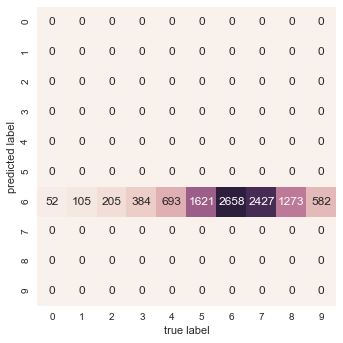

Baseline model
RMSE: 1.6847254969282088
Weighed RMSE: 3.9450793239484825
MAE: 1.2535


In [443]:
#baseline assumes predictions are equal to mean of ratings
corpus['baseline_pred'] = 7
labels = corpus['baseline_pred']

mat = confusion_matrix(corpus.rating.astype('int'), labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False )
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

assess_model("Baseline model", y,labels)

## Multinomial NB Model

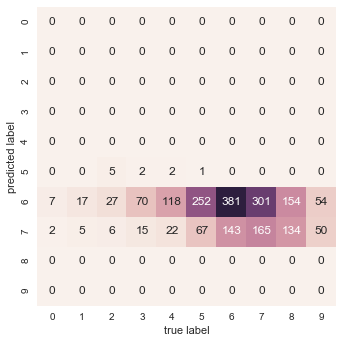

Multinomial NB
RMSE: 1.6611703131963922
Weighed RMSE: 4.045193704288626
MAE: 1.23424185


In [536]:
X_train, X_test, y_train, y_test = train_test_split(corpus.cleaned, corpus.rating, test_size=0.20)

model_nb = Pipeline([
    ('count_vectorizer', CountVectorizer(lowercase = True, stop_words = stopwords.words('english'))), 
    ('tfidf_transformer',  TfidfTransformer()), #weighs terms by importance to help with feature selection
    ('classifier', MultinomialNB()) ])
    
model_nb.fit(X_train,y_train.astype('int'))
labels = model_nb.predict(X_test)
mat = confusion_matrix(y_test.astype('int'), labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False )
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

assess_model("Multinomial NB", y_test,labels)

## Multinomial NB with N-grams 

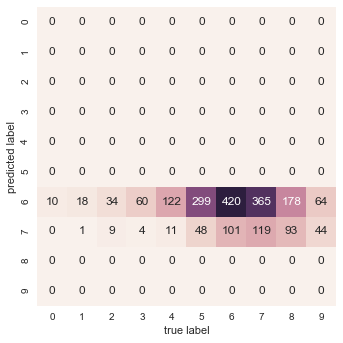

Multinomial NB n-grams 1-2
RMSE: 1.6344047393470198
Weighed RMSE: 3.979733900798947
MAE: 1.223114


In [538]:
#Experimented with adding different numbers of n-grams, 1-2 seems to have best performance
X_train, X_test, y_train, y_test = train_test_split(corpus.cleaned, corpus.rating, test_size=0.20)

model_nb2 = Pipeline([
    ('count_vectorizer', CountVectorizer( ngram_range=(1, 2), lowercase = True, stop_words = stopwords.words('english'))), 
    ('tfidf_transformer',  TfidfTransformer()), #weighs terms by importance to help with feature selection
    ('classifier', MultinomialNB()) ])
    
model_nb2.fit(X_train,y_train.astype('int'))
labels = model_nb2.predict(X_test)
mat = confusion_matrix(y_test.astype('int'), labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False )
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

assess_model("Multinomial NB n-grams 1-2", y_test,labels)

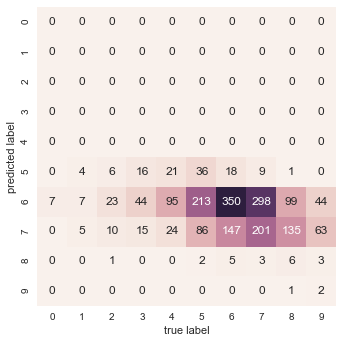

Multinomial NB tuned
RMSE: 1.57544071310221
Weighed RMSE: 3.7708580366619584
MAE: 1.1579145


In [539]:
#Further tune the Multinomial NB model
X_train, X_test, y_train, y_test = train_test_split(corpus.cleaned, corpus.rating, test_size=0.20)

model_nb3 = Pipeline([
    ('count_vectorizer', CountVectorizer( ngram_range=(1, 2), min_df=10, lowercase = True, stop_words = stopwords.words('english'))), 
    ('tfidf_transformer',  TfidfTransformer()), #weighs terms by importance to help with feature selection
    ('classifier', MultinomialNB()) ])
    
model_nb3.fit(X_train,y_train.astype('int'))
labels = model_nb3.predict(X_test)
mat = confusion_matrix(y_test.astype('int'), labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False )
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

assess_model("Multinomial NB tuned", y_test,labels)

## LinearSVC Model

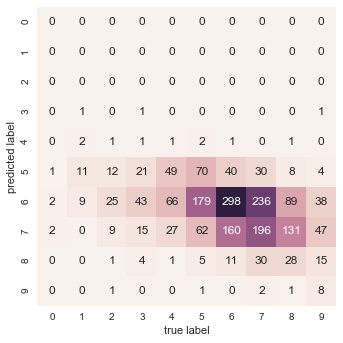

Linear SVC model
RMSE: 1.5987848462191525
Weighed RMSE: 3.5581424692905275
MAE: 1.1636765


In [540]:
X_train, X_test, y_train, y_test = train_test_split(corpus.cleaned, corpus.rating, test_size=0.20)
model_svc = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), svm.SVC(kernel="linear"))
model_svc.fit(X_train, y_train.astype('int'))
labels = model_svc.predict(X_test)

mat = confusion_matrix(y_test.astype('int'), labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False )
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

assess_model("Linear SVC model", y_test,labels)

## Try using balanced sample of review data

In [57]:
corpus = pd.read_csv('reviews_sampled.csv')
sampled_corpus = clean_text(corpus)
sampled_corpus.head()

,Unnamed: 0,Compiled from boardgamegeek.com by Matt Borthwick,gameID,rating,comment,rating_int,cleaned
0,253100,189543,2223,1.0,"Crap, but you already knew that.",1,crap already knew
1,708026,121475,172225,1.0,"Horrible gameplay, completely random.",1,horrible gameplay completely random
2,112196,186372,181,1.0,Classic game. Really awful luck mechanics and ...,1,classic really awful luck mechanics card bonus...
3,207423,176706,1406,1.0,Possibly the game I hate most in this world.,1,possibly hate world
4,420097,151012,50381,1.0,I would rather sit and stare at a wall than pl...,1,would rather sit stare wall


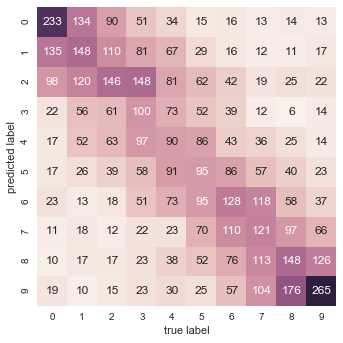

Multinomial NB predicted on balanced data
RMSE: 2.4758163636802037
Weighed RMSE: 2.7148594269530824
MAE: 1.73133333333


In [557]:
#Further tune the Multinomial NB model
X_train, X_test, y_train, y_test = train_test_split(sampled_corpus.cleaned, sampled_corpus.rating.astype(int), test_size=0.20)

model_balanced = Pipeline([
    ('count_vectorizer', CountVectorizer( ngram_range=(1, 2), min_df=10, lowercase = True, stop_words = stopwords.words('english'))), 
    ('tfidf_transformer',  TfidfTransformer()), #weighs terms by importance to help with feature selection
    ('classifier', MultinomialNB()) ])
    
model_balanced.fit(X_train,y_train.astype('int'))
labels = model_balanced.predict(X_test)
mat = confusion_matrix(y_test.astype('int'), labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False )
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

assess_model("Multinomial NB predicted on balanced data", y_test,labels)


In [560]:
#join results of Multinomial NB models on balanced and unbalanced data to create ensemble model

X_train, X_test, y_train, y_test = train_test_split(corpus.cleaned, corpus.rating, test_size=0.20)

labels = model_nb3.predict(X_test)
labels_2 = model_balanced.predict(X_test)


pred = pd.concat([pd.DataFrame(y_test).reset_index().rating,pd.Series(labels),pd.Series(labels_2)],axis=1)
pred.columns = ['rating','model_1','model_2']

pred = pd.concat([pd.DataFrame(y_test).reset_index().rating,pd.Series(labels),pd.Series(labels_2)],axis=1)
pred.columns = ['rating','model_1','model_2']

pred['final'] = np.where(pred.model_2 >= 3, np.where(pred.model_2 <= 9, pred.model_1, pred.model_2), pred.model_2)
#pred['final'] = np.where(pred.model_2 <= 9, pred.model_1, pred.model_2)
pred.tail()

,rating,model_1,model_2,final
1995,8.0,7,7,7
1996,7.5,7,7,7
1997,8.0,8,9,8
1998,7.0,7,9,7
1999,7.0,7,9,7


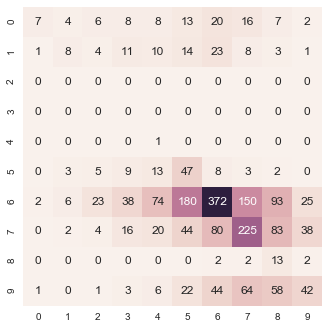

Ensemble model
RMSE: 2.1246566257739157
Weighed RMSE: 3.125007574690423
MAE: 1.40104585


In [562]:
mat = confusion_matrix(pred.rating.astype(int), pred.final)
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False )
plt.show()
assess_model("Ensemble model", pred.rating,pred.final)

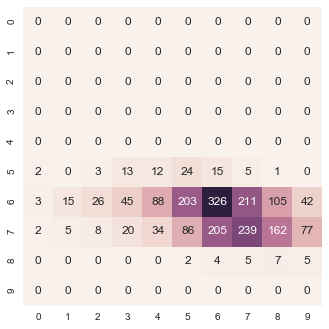

Ensemble model
RMSE: 1.6138491972625568
Weighed RMSE: 3.8454411830651107
MAE: 1.18101205


In [569]:
#create ensemble model using VotingClassifier

X_train, X_test, y_train, y_test = train_test_split(corpus.cleaned, corpus.rating, test_size=0.20)

Ensemble = VotingClassifier(estimators=[('nb',model_nb3 ), ('sampled_nb', model_balanced)],
                        voting='soft',
                        weights=[1, 1])

Ensemble.fit(X_train,y_train)


labels = Ensemble.predict(X_test)
mat = confusion_matrix(y_test.astype(int), labels)
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False )
plt.show()
assess_model("Ensemble model", y_test,labels)

In [576]:
#predict the test set using the best model 
test = pd.read_csv('boardgame-comments-english-test.csv')
test.columns = ['userID','gameID','comment']

test = clean_text(test)
test.head()

,userID,gameID,comment,cleaned
0,140134,205637,This game is the first game that totally left ...,first totally left satisfied hit nail head fac...
1,184733,2163,I got into this game just as the first edition...,got first edition went print able buy basic se...
2,17204,15158,This expansion has some edges but I like it be...,expansion edges like forces change tactics dra...
3,79036,35677,Why bother with Le Havre if you can play Agric...,bother le havre agricola sorry say theme agric...
4,188085,155426,Fun enough to discover and tinker around with....,fun enough discover tinker around approaching ...


In [577]:
labels = Ensemble.predict(test.cleaned) 

In [578]:
#append predictions
test = pd.read_csv('boardgame-comments-english-test.csv')
labels = pd.Series(labels)
pred = pd.concat([test,labels],axis=1)
pred.to_csv('test_predictions.csv',index=False)

In [579]:
pred

,Compiled from boardgamegeek.com by Matt Borthwick,gameID,comment,0
0,140134,205637,This game is the first game that totally left ...,8.0
1,184733,2163,I got into this game just as the first edition...,7.0
2,17204,15158,This expansion has some edges but I like it be...,8.0
3,79036,35677,Why bother with Le Havre if you can play Agric...,8.0
4,188085,155426,Fun enough to discover and tinker around with....,7.0
5,82907,147151,At first I thought: it's a nice idea but not s...,7.0
6,12961,39856,One of the best party games. Cards are fantast...,8.0
7,93054,93,Played 4/14/2006.,7.0
8,125298,5,It takes a while to wrap your head around the ...,7.0
9,48901,13,"Decent, really overplayed this when a gf of mi...",6.0
